In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import numpy as np
import pandas as pd
import pickle
import scipy.stats
import seaborn as sns

1\. **Color-coded scatter plot**

Produce a scatter plot from a dataset with two categories.

* Write a function that generates a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and standard deviation. Set different values of the mean and stardand deviation between the two samples.
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below:

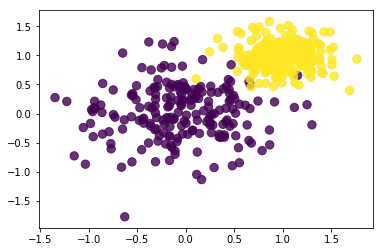

In [27]:
from IPython.display import Image
Image('two_categories_scatter_plot.png')

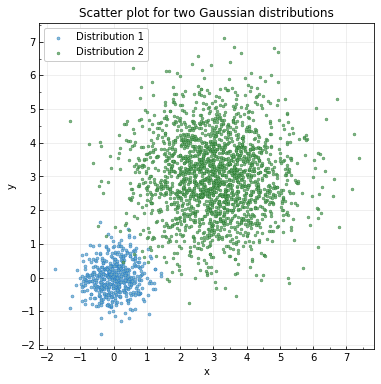

In [28]:
gaus1 = np.random.normal(loc=0., scale=0.5, size=(500, 250))
gaus2 = np.random.normal(loc=3., scale=1.2, size=(2000, 1000))

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(gaus1[:,0], gaus1[:,1], marker='.', color='#75aebf', label='Distribution 1', edgecolor='#1874cd', alpha=0.8, lw=0.5)
ax.set_title('Scatter plot for two Gaussian distributions')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.scatter(gaus2[:,0], gaus2[:,1], marker='.', color='#62a36d', label='Distribution 2', edgecolor='darkgreen', alpha=0.8, lw=0.3)
ax.legend(framealpha = 1)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(which='both', direction='in')

ax.grid(which='major', axis='both', alpha=0.25)
ax.set_axisbelow(True)

2\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following pickle file:
```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```
* Inspect the dataset, you'll find two variables (features)
* Convert the content to a Pandas Dataframe
* Clean the sample by selecting the entries (rows) with the absolute values of the variable "residual" smaller than 2
* Plot a Seaborn jointplot of "residuals" versus "distances", and use seaborn to display a linear regression. 

Comment on the correlation between these variables.

* Create manually (without using seaborn) the profile histogram for the "distance" variable; choose an appropriate binning.
* Obtain 3 numpy arrays:
  * `x`, the array of bin centers of the profile histogram of the "distance" variable
  * `y`, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * `err_y`, the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

{'residuals': array([ 1.1       , -1.95      , -7.2       , ...,  0.08333333,
        0.16666667,  0.08333333]), 'distances': array([16. ,  6.3,  3.4, ...,  1.7, 19.1,  2.6])}
       residuals  distances
0       1.100000       16.0
1      -1.950000        6.3
8      -0.042857        3.3
9       0.128571        5.3
10      0.085714       15.0
...          ...        ...
11126  -0.760000       14.4
11127   0.380000        7.5
11128   0.083333        1.7
11129   0.166667       19.1
11130   0.083333        2.6

[10489 rows x 2 columns]
There seems to be a correlation between the two variables, but computing the correlation factor one obtaines, 0.043, a quite low value


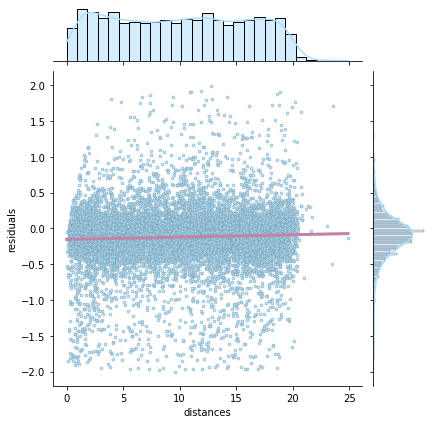

In [40]:
# ex 2

#!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/

# 2.1
with open('data/residuals_261.pkl', 'rb') as infile:
    X = pickle.load(infile)
print(X)

# 2.2
mydict = dict(X.item())
df = pd.DataFrame(mydict)

#2.3
df_clean = df[abs(df['residuals'])<2.]
print(df_clean)

# 2.4
sns.jointplot(x='distances', y='residuals', data=df_clean, kind="reg", marker='.', color='#aadeff',
scatter_kws={"alpha":0.8, "edgecolor":'#7998a3', "lw":0.5}, line_kws={"color":"#c482aa", "linewidth":3})

print('There seems to be a correlation between the two variables, but computing the correlation factor one obtaines, %1.3f, a quite low value' %np.corrcoef(df_clean['distances'], df_clean['residuals'])[0,1])

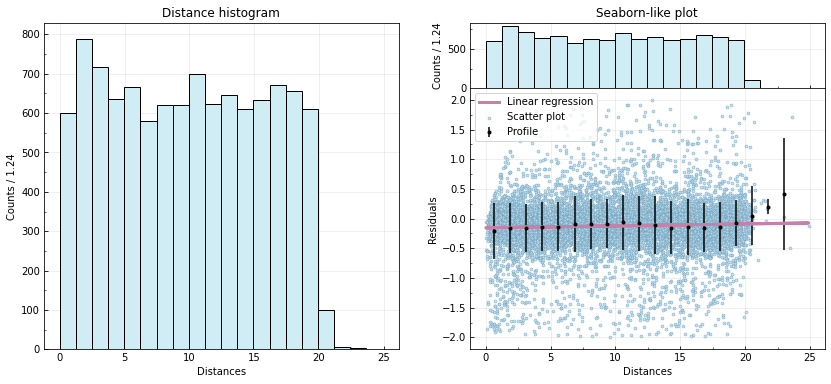

In [56]:
from matplotlib import gridspec

# 2.5
nbins = 20
fig = plt.figure(figsize=(14,6))
gs = gridspec.GridSpec(2, 2, height_ratios=[0.5, 2]) 
ax0 = plt.subplot(gs[:,0])
hist, edges, _ = ax0.hist(df_clean['distances'], bins=nbins, color='#d0ecf5', edgecolor='black')
binwidth = edges[1]-edges[0]
ax0.set_title('Distance histogram')
ax0.set_xlabel('Distances')
ax0.set_ylabel('Counts / %.2f'%binwidth)
ax0.grid(which='major', axis='both', alpha=0.25)
ax0.set_axisbelow(True)
ax0.xaxis.set_minor_locator(AutoMinorLocator(2))
ax0.yaxis.set_minor_locator(AutoMinorLocator(2))
ax0.tick_params(which='both', direction='in')

# 2.6
x = []
y = []
err_y = []
for i in range(nbins - 1):
    dfi = df_clean[(df_clean['distances'] > edges[i]) & (df_clean['distances'] < edges[i+1])]
    x.append(np.mean([edges[i], edges[i+1]]))
    y.append(np.mean(dfi['residuals']))
    err_y.append(np.std(dfi['residuals']))
x = np.array(x)
y = np.array(y)
err_y = np.array(err_y)

# 2.7 - creating a seaborn-like plot manually, putting the profile for distances on top of the scatter plot
ax1 = plt.subplot(gs[0,1])
ax1.hist(df_clean['distances'], bins=nbins, color='#d0ecf5', edgecolor='black')
ax1.set_xlabel('Distances')
ax1.set_ylabel('Counts / %.2f'%binwidth)
ax1.grid(which='major', axis='both', alpha=0.25)
ax1.set_axisbelow(True)
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))
ax1.tick_params(which='both', direction='in')
ax2 = plt.subplot(gs[1,1], sharex = ax1)
ax2.scatter(df_clean['distances'], df_clean['residuals'], marker='.', color='#aadeff', alpha=0.8, edgecolor='#7998a3', lw=0.5, label='Scatter plot')
ax1.set_title('Seaborn-like plot')
ax2.set_xlabel('Distances')
ax2.set_ylabel('Residuals')
ax2.grid(which='major', axis='both', alpha=0.25)
ax2.set_axisbelow(True)
ax2.xaxis.set_minor_locator(AutoMinorLocator(2))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.tick_params(which='both', direction='in')
plt.setp(ax1.get_xticklabels(), visible=False)
yticks = ax2.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
plt.subplots_adjust(hspace=.0)
m, q, rvalue, pvalue, err = scipy.stats.linregress(df_clean['distances'], df_clean['residuals'])
ax2.plot(df['distances'], q+m*df['distances'], color='#c482aa', label='Linear regression', lw=3)
ax2.errorbar(x=x, y=y, yerr=err_y, label="Profile", color='black', marker='.', linestyle="")
ax2.legend(loc='upper left')

3\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn):

* Fill a numpy array `x` of length N (with $N=\mathcal{O}(100)$) with a variable normally distributed, with a given mean and standard deviation
* Fill an histogram in pyplot taking proper care of the aesthetic:
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* For every element of `x`, create a gaussian with the mean corresponding to the element value and the standard deviation as a parameter that can be tuned. The standard deviation default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with `np.sum()`) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method. Superimpose the normalized sum of all gaussians to the first histogram.


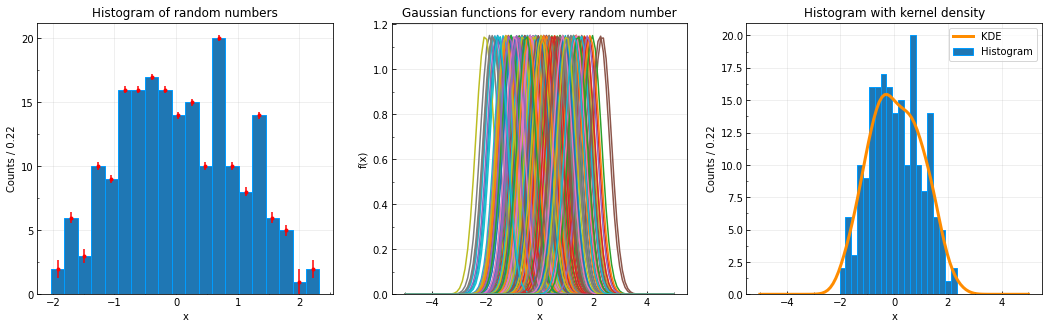

In [32]:
# ex 3

# 3.1
N = 200
x = np.random.normal(loc=0., scale=1, size=(N))

# 3.2
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
entries, edges, _ = ax1.hist(x, bins=20, edgecolor='#009cff')
binwidth = edges[1]-edges[0]
ax1.set_title('Histogram of random numbers')
ax1.set_xlabel('x')
ax1.set_ylabel('Counts / %.2f'%binwidth)
ax1.grid(which='major', axis='both', alpha=0.25)
ax1.set_axisbelow(True)
ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.yaxis.set_major_locator(MultipleLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))
ax1.tick_params(which='both', direction='in')
bin_centers = 0.5 * (edges[:-1] + edges[1:])
ax1.errorbar(bin_centers, entries, yerr=(1/np.sqrt(entries)), fmt='r.')

# 3.3
std_dev = 1.06*np.std(x)*pow(np.size(x), -0.2)
x_space = np.linspace(-5, 5, 100)
gauss = np.array([scipy.stats.norm.pdf(x_space, loc=i, scale=std_dev) for i in x])

# 3.4
ax2.plot(x_space, np.transpose(gauss))
ax2.set_title('Gaussian functions for every random number')
ax2.set_xlabel('x')
ax2.set_ylabel('f(x)')
ax2.grid(which='major', axis='both', alpha=0.25)
ax2.set_axisbelow(True)
ax2.xaxis.set_minor_locator(AutoMinorLocator(2))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.tick_params(which='both', direction='in')
ax2.set_ylim(bottom=0)

# 3.5
gauss_sum = np.sum(gauss, axis=0)
binswidth = edges[1] - edges[0]
kde =  (gauss_sum)*N*(binswidth)/scipy.integrate.trapz(gauss_sum, x_space) 

ax3.plot(x_space, kde, color='darkorange', lw=3, label='KDE')
ax3.hist(x, bins=20, edgecolor='#009cff', label='Histogram')
ax3.set_title('Histogram with kernel density')
ax3.set_xlabel('x')
ax3.set_ylabel('Counts / %.2f'%binwidth)
ax3.grid(which='major', axis='both', alpha=0.25)
ax3.set_axisbelow(True)
ax3.xaxis.set_minor_locator(AutoMinorLocator(2))
ax3.yaxis.set_minor_locator(AutoMinorLocator(2))
ax3.tick_params(which='both', direction='in')
ax3.legend()